# Compare performance across concentration and representation

Compare classifier metrics across different consensus profile strategies, stratefied by representations types. 

In [21]:
import polars as pl 
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import MultiComparison
import warnings

## Input annotations

In [ ]:
endpoint_types = ["toxcast_cellbased", "toxcast_cellfree", "toxcast_cytotox", "axiom"]

pred_df = []
for et in endpoint_types:
    preds = pl.read_parquet(f"../compiled_results/compiled_{et}_metrics.parquet")
    preds = preds.with_columns(
        (pl.col("Metadata_Count_0") + pl.col("Metadata_Count_1")).alias("Total_Compounds"),
        pl.lit(et).alias("Endpoint_type")
    )
    pred_df.append(preds)

pred_df = pl.concat(pred_df, how="vertical")
pred_df = pred_df.with_columns(
    pl.when(pl.col("Endpoint_type") == "axiom").then(pl.lit("axiom_cytotox")).otherwise(pl.col("Endpoint_type")).alias("Endpoint_type")
)

pred_df = pred_df.filter(pl.col("Model_type") == "Actual")

### Compare concentrations and representations

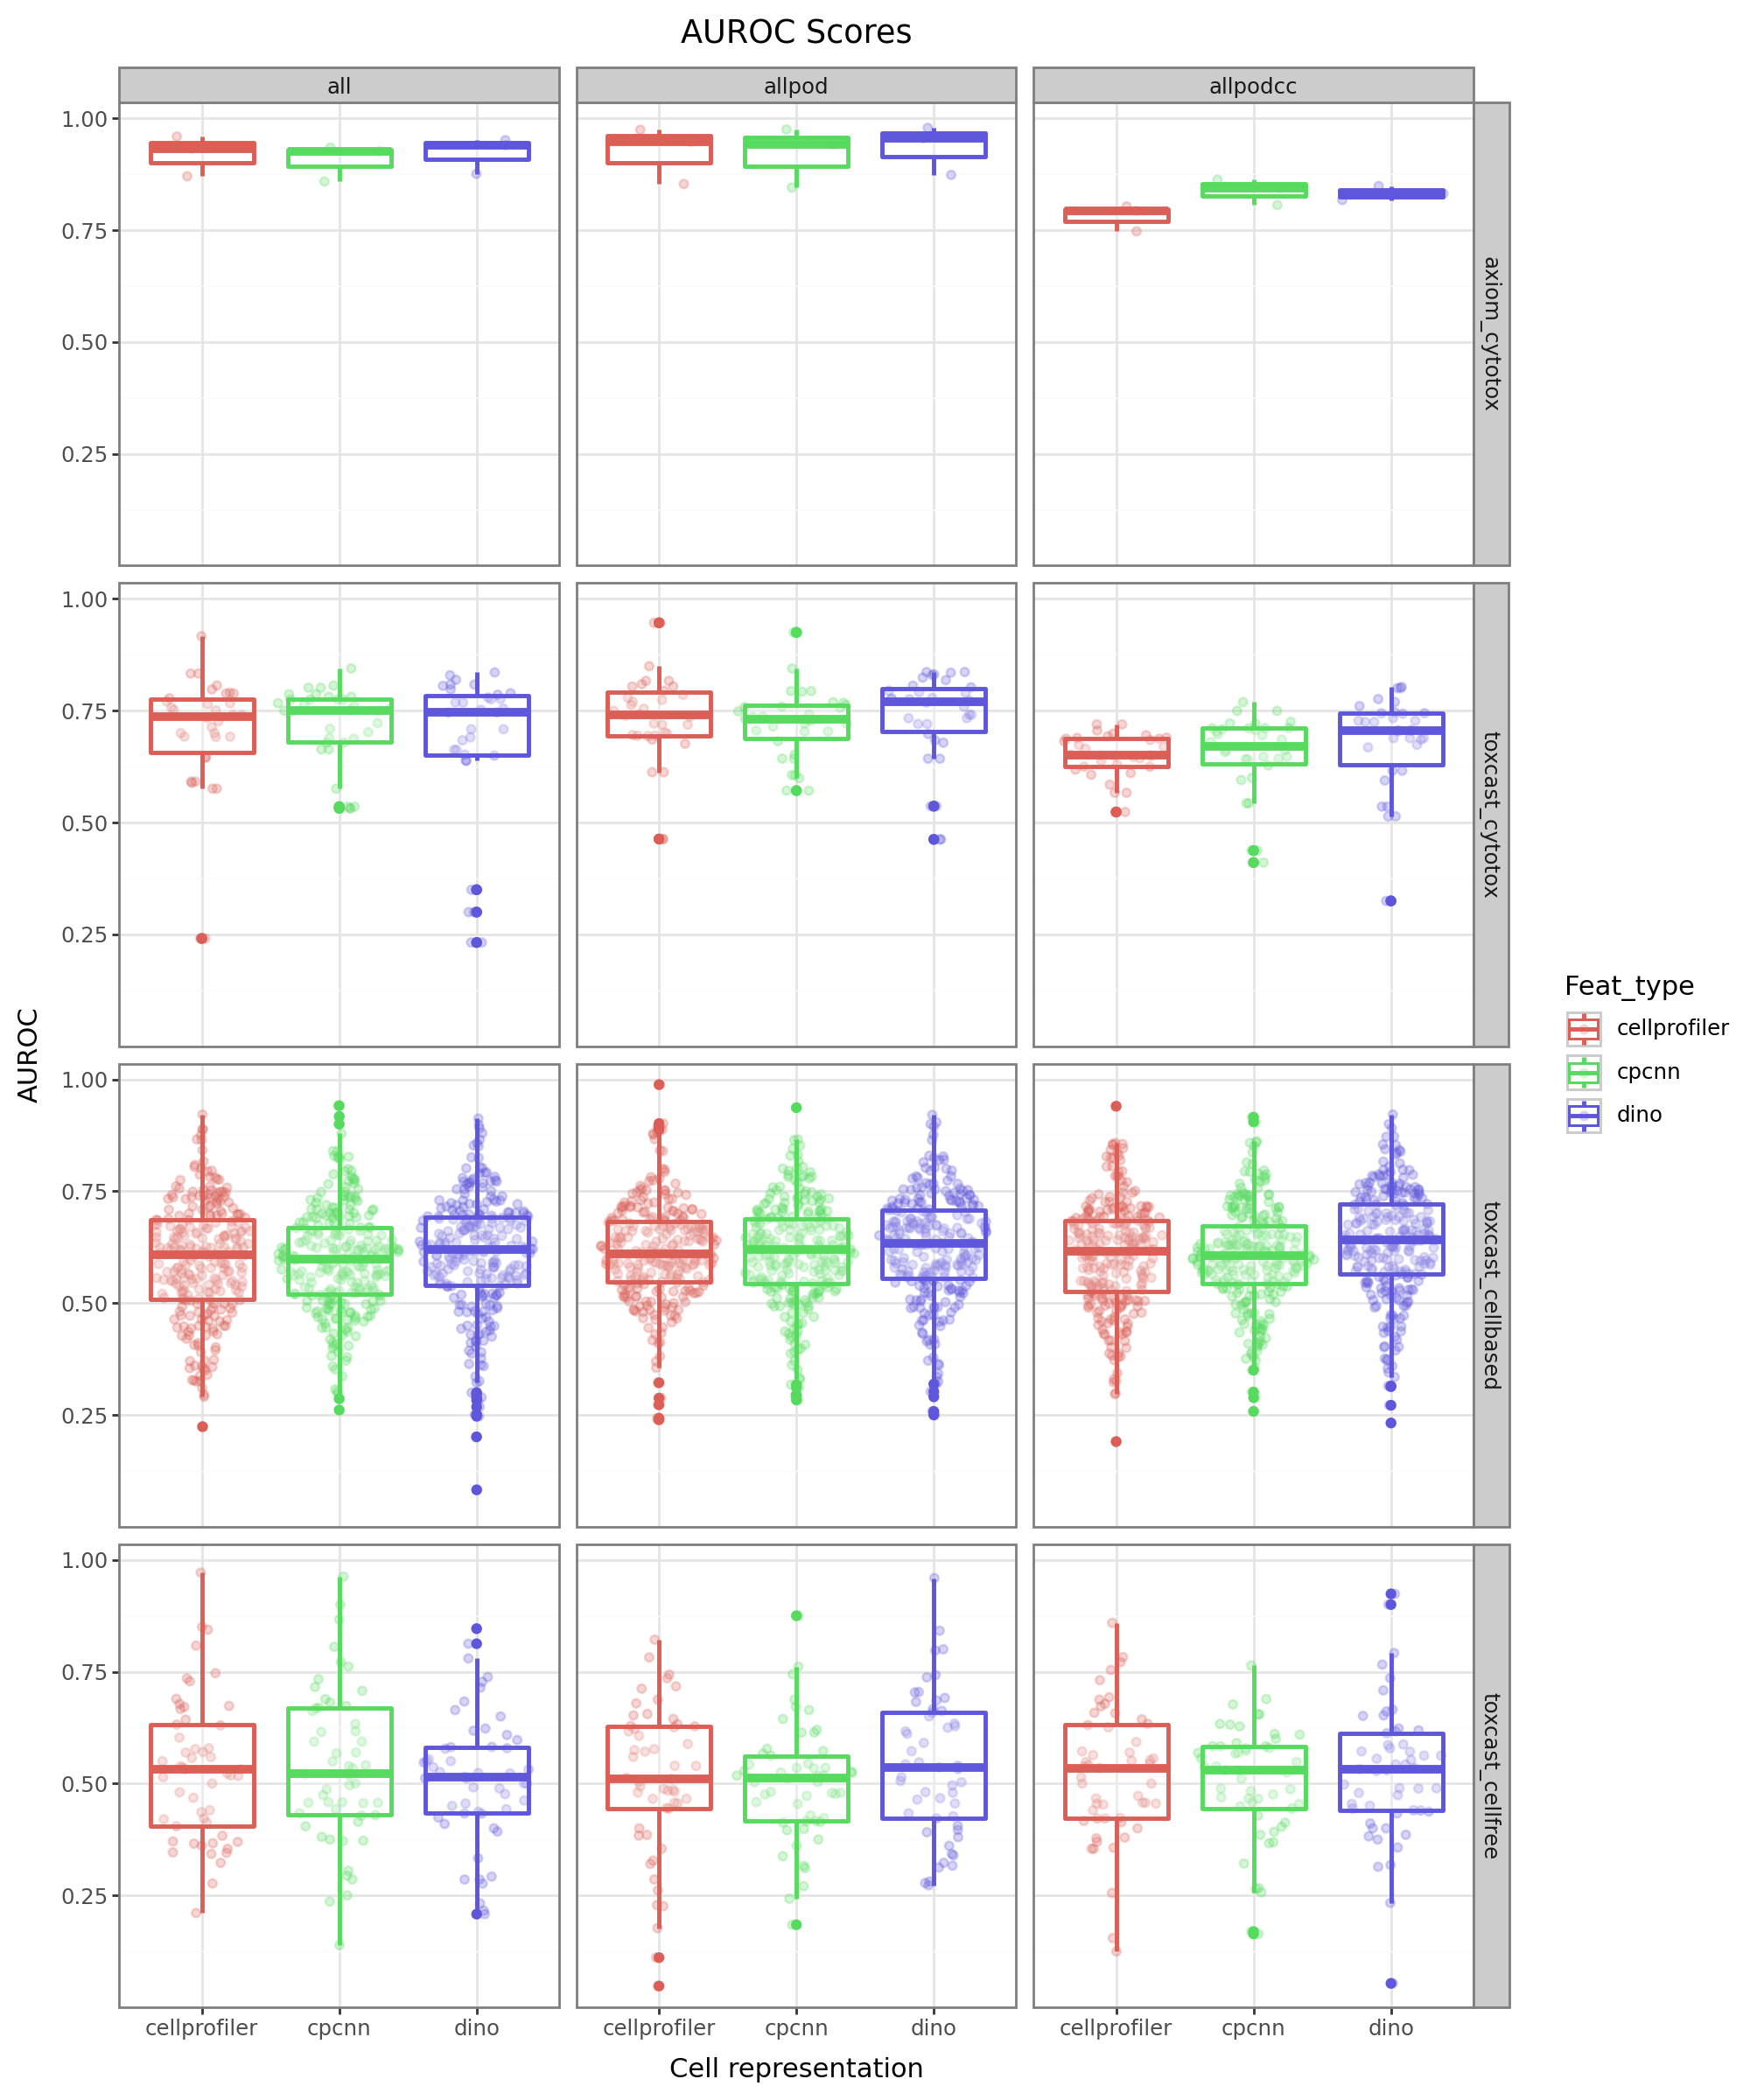

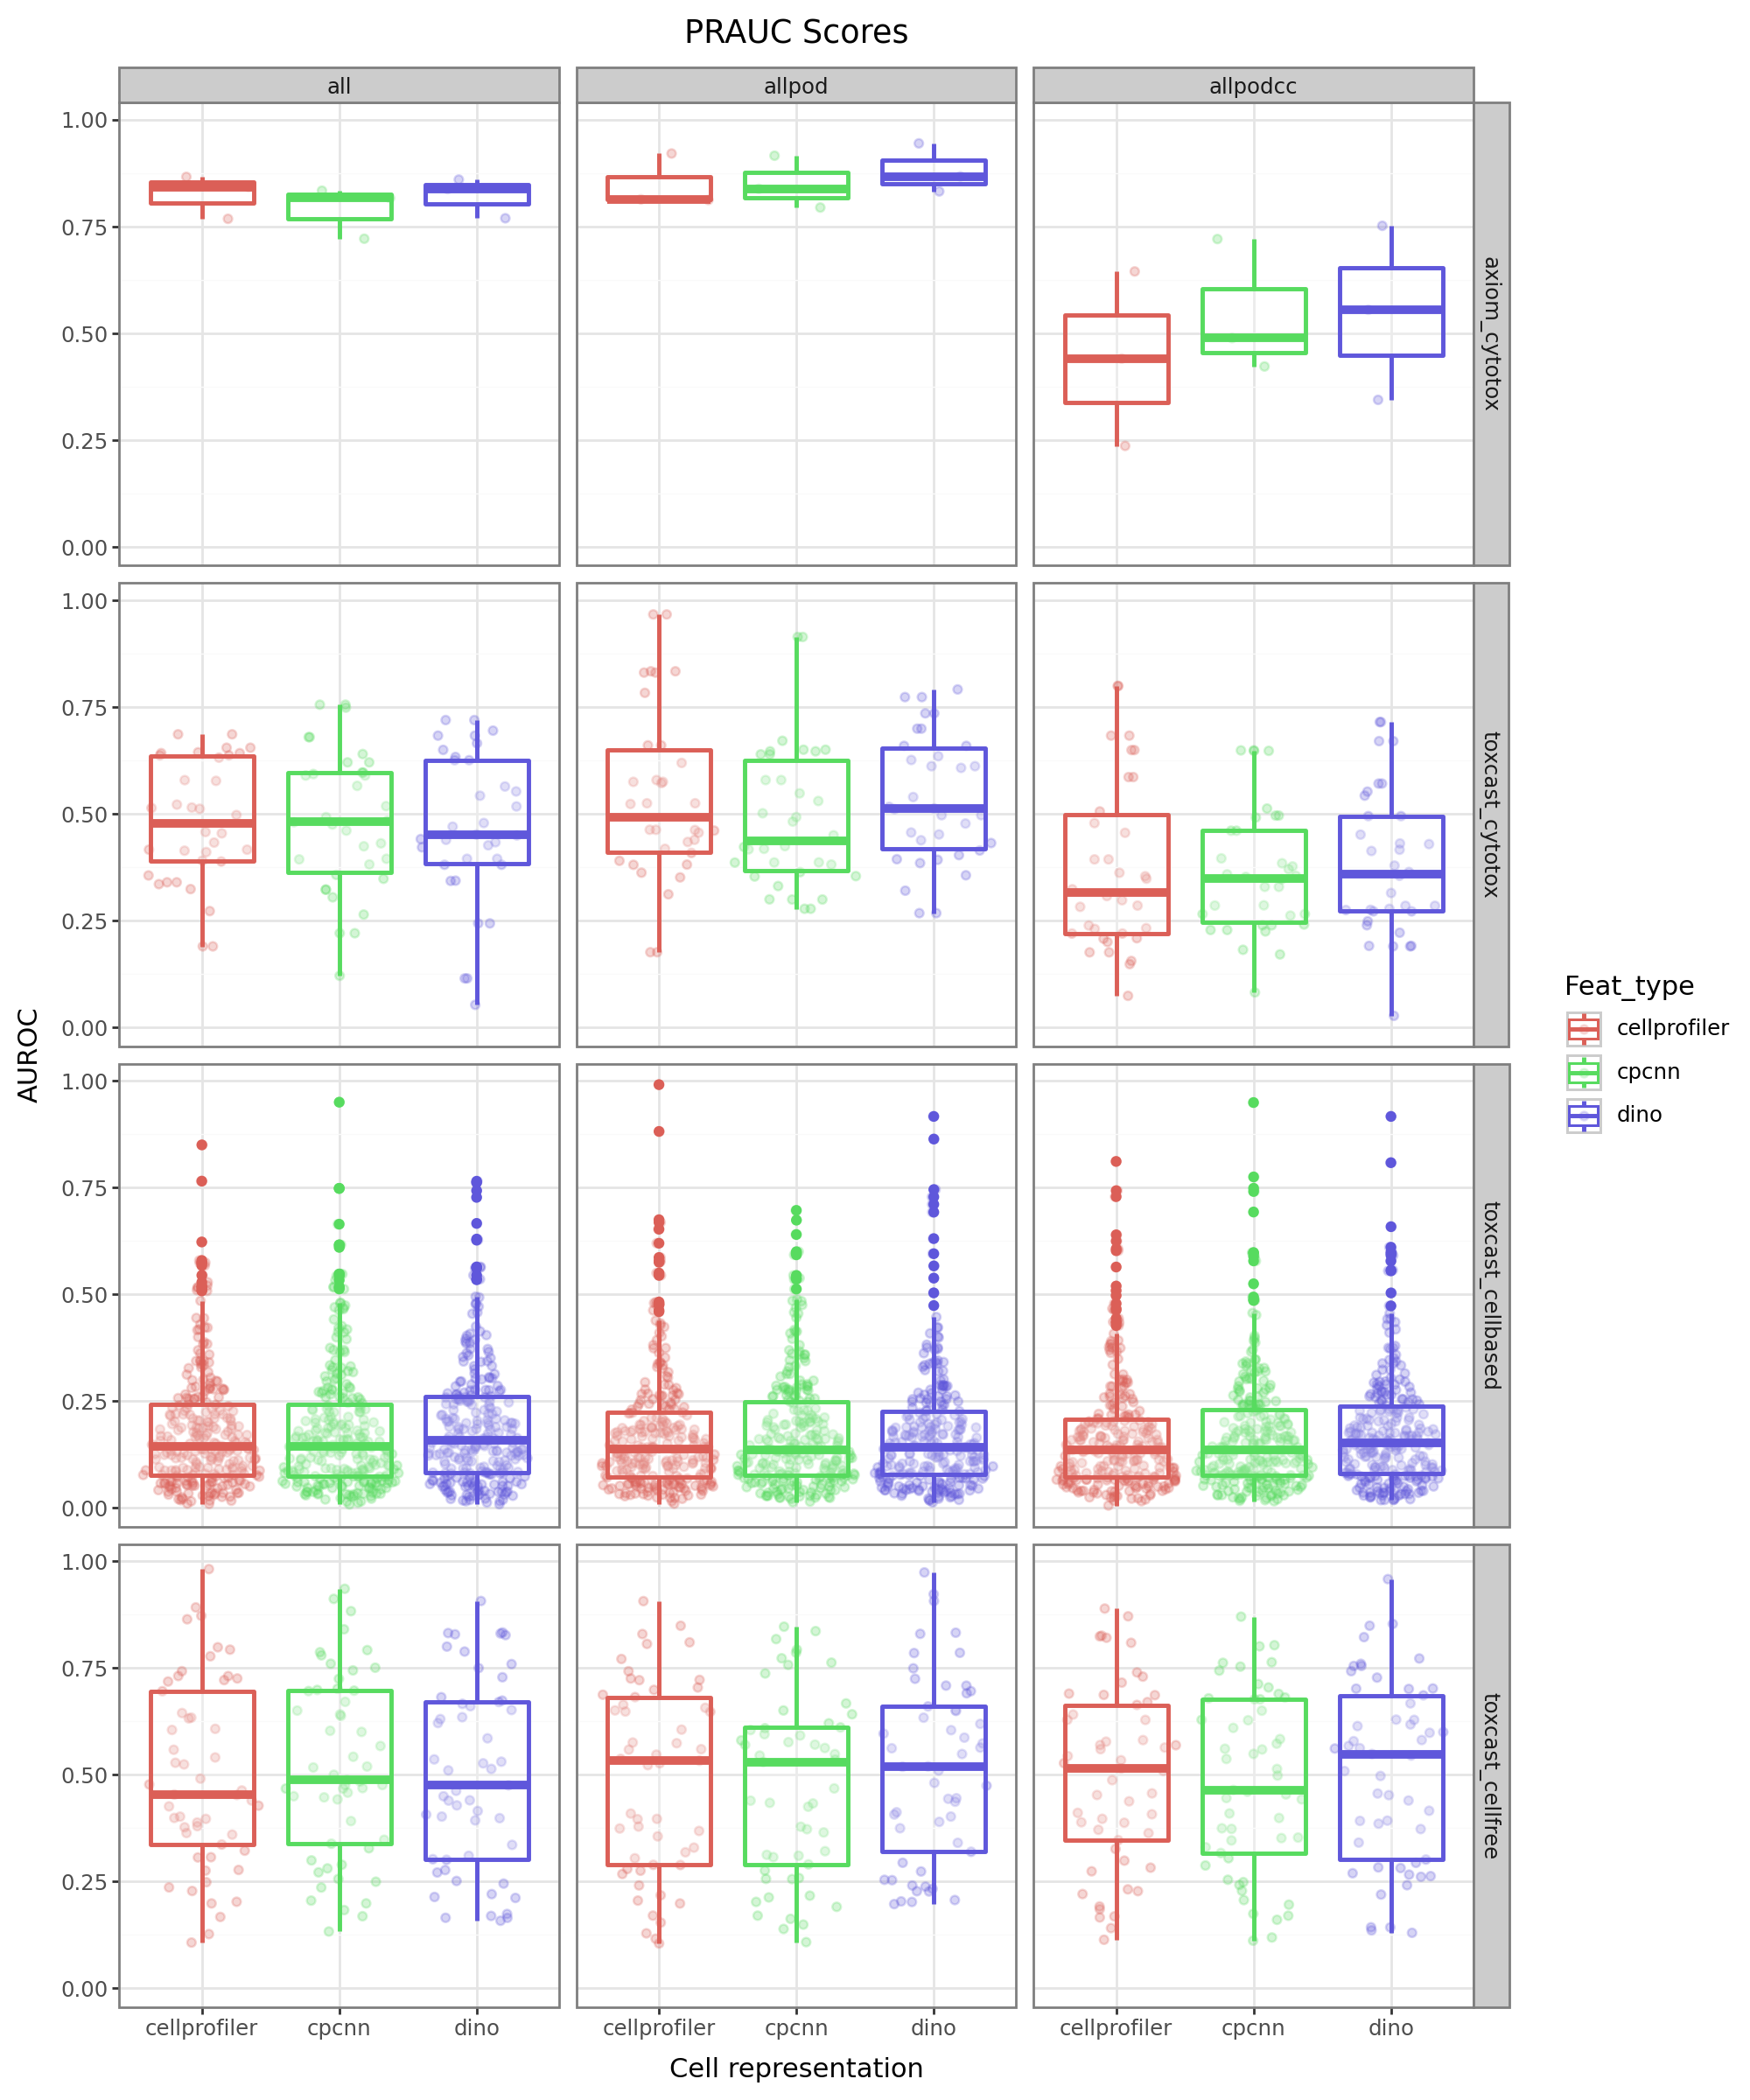

In [19]:
from plotnine import ggplot, aes, geom_sina, geom_boxplot, labs, theme_bw, position_dodge, facet_grid
import plotnine as pn

pn.options.figure_size = (10, 12)

pred_pandas = pred_df.to_pandas()
pred_pandas['Endpoint_type'] = pd.Categorical(
    pred_pandas['Endpoint_type'], 
    categories=["axiom_cytotox", "toxcast_cytotox", "toxcast_cellbased", "toxcast_cellfree"],
    ordered=True
)

plot = (
    ggplot(pred_pandas, aes(x='Feat_type', y='AUROC', color="Feat_type")) 
    + geom_sina(alpha=0.25) 
    + geom_boxplot(alpha=0.25, size=1)
    + facet_grid("Endpoint_type ~ Metadata_AggType")
    + labs(title='AUROC Scores', x='Cell representation', y='AUROC') 
    + theme_bw()
)
plot.show()

plot = (
    ggplot(pred_pandas, aes(x='Feat_type', y='PRAUC', color="Feat_type")) 
    + geom_sina(alpha=0.25) 
    + geom_boxplot(alpha=0.25, size=1)
    + facet_grid("Endpoint_type ~ Metadata_AggType")
    + labs(title='PRAUC Scores', x='Cell representation', y='AUROC') 
    + theme_bw()
)
plot.show()

## Compute statistics

### Across consensus strategies

In [22]:
warnings.filterwarnings("ignore")

# Fit the mixed-effects model
model = smf.mixedlm(
    "AUROC ~ Metadata_AggType", 
    pred_pandas, 
    groups=pred_pandas["Metadata_Label"],
    re_formula="~Feat_type"
)
result = model.fit()

# Add fitted values to the subset DataFrame
pred_pandas["fitted_values"] = result.fittedvalues

# Perform Tukey's HSD
mc = MultiComparison(pred_pandas["fitted_values"], pred_pandas["Metadata_AggType"])
tukey_result = mc.tukeyhsd()
tukey_pvals = tukey_result.pvalues

# Print results for the current Endpoint_type
print(tukey_result.summary())
print("P-values:", tukey_pvals)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1  group2  meandiff p-adj   lower   upper  reject
------------------------------------------------------
   all   allpod   0.0149 0.0003   0.006  0.0238   True
   all allpodcc   0.0059 0.2653  -0.003  0.0148  False
allpod allpodcc   -0.009 0.0466 -0.0179 -0.0001   True
------------------------------------------------------
P-values: [2.57932957e-04 2.65307034e-01 4.66184987e-02]


In [23]:
warnings.filterwarnings("ignore")

# Fit the mixed-effects model
model = smf.mixedlm(
    "PRAUC ~ Metadata_AggType", 
    pred_pandas, 
    groups=pred_pandas["Metadata_Label"],
    re_formula="~Feat_type"
)
result = model.fit()

# Add fitted values to the subset DataFrame
pred_pandas["fitted_values"] = result.fittedvalues

# Perform Tukey's HSD
mc = MultiComparison(pred_pandas["fitted_values"], pred_pandas["Metadata_AggType"])
tukey_result = mc.tukeyhsd()
tukey_pvals = tukey_result.pvalues

# Print results for the current Endpoint_type
print(tukey_result.summary())
print("P-values:", tukey_pvals)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1  group2  meandiff p-adj   lower   upper  reject
------------------------------------------------------
   all   allpod  -0.0051 0.8137 -0.0246  0.0144  False
   all allpodcc  -0.0229 0.0167 -0.0424 -0.0033   True
allpod allpodcc  -0.0178  0.083 -0.0373  0.0017  False
------------------------------------------------------
P-values: [0.81368203 0.01665304 0.08301654]


### Across representations

In [24]:
warnings.filterwarnings("ignore")

# Fit the mixed-effects model
model = smf.mixedlm(
    "AUROC ~ Feat_type", 
    pred_pandas, 
    groups=pred_pandas["Metadata_Label"],
    re_formula="~Metadata_AggType"
)
result = model.fit()

# Add fitted values to the subset DataFrame
pred_pandas["fitted_values"] = result.fittedvalues

# Perform Tukey's HSD
mc = MultiComparison(pred_pandas["fitted_values"], pred_pandas["Feat_type"])
tukey_result = mc.tukeyhsd()
tukey_pvals = tukey_result.pvalues

# Print results for the current Endpoint_type
print(tukey_result.summary())
print("P-values:", tukey_pvals)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
   group1    group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------------
cellprofiler  cpcnn  -0.0013 0.9376 -0.0102 0.0076  False
cellprofiler   dino   0.0131 0.0016  0.0042  0.022   True
       cpcnn   dino   0.0144 0.0004  0.0055 0.0233   True
---------------------------------------------------------
P-values: [9.37589976e-01 1.56247474e-03 4.22547971e-04]


In [25]:
warnings.filterwarnings("ignore")

# Fit the mixed-effects model
model = smf.mixedlm(
    "PRAUC ~ Feat_type", 
    pred_pandas, 
    groups=pred_pandas["Metadata_Label"],
    re_formula="~Metadata_AggType"
)
result = model.fit()

# Add fitted values to the subset DataFrame
pred_pandas["fitted_values"] = result.fittedvalues

# Perform Tukey's HSD
mc = MultiComparison(pred_pandas["fitted_values"], pred_pandas["Feat_type"])
tukey_result = mc.tukeyhsd()
tukey_pvals = tukey_result.pvalues

# Print results for the current Endpoint_type
print(tukey_result.summary())
print("P-values:", tukey_pvals)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
   group1    group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------------
cellprofiler  cpcnn  -0.0007 0.9956 -0.0204 0.0189  False
cellprofiler   dino   0.0075 0.6411 -0.0121 0.0272  False
       cpcnn   dino   0.0083 0.5845 -0.0114  0.028  False
---------------------------------------------------------
P-values: [0.99562601 0.64108745 0.58451363]
